#  NSGA-II with external archive

The quality of the fronts obtained by NSGA-II can be improved if an external archive is incorporated into the algorithm. In this notebook, we show how to use an external bounded archive based on the crowding distance density estimator and compare the results of NSGA-II with and without using the archive. We start first showing the front obtained with the standard NSGA-II. The target problem is ZDT1.

In [1]:
include("../src/bounds.jl")
include("../src/solution.jl")
include("../src/operator.jl")
include("../src/continuousProblem.jl")
include("../src/algorithm.jl")
include("../src/component.jl")
include("../src/utils.jl")

using Dates

## Problem to solve: ZDT1

In [2]:
problem = zdt1Problem()

ContinuousProblem{Float64}(Bounds{Float64}[Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0)  …  Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0)], Function[var"#97#100"(), var"#98#101"{var"#evalG#99"}(var"#evalG#99"())], Function[], "ZDT1")

## Standard NSGA-II configured to find 100 solutions

In [3]:
solver::NSGAII = NSGAII()
solver.problem = problem
solver.populationSize = 100

solver.termination = TerminationByEvaluations((numberOfEvaluationsToStop = 25000, ))
solver.mutation = PolynomialMutation((probability=1.0/numberOfVariables(problem), distributionIndex=20.0, bounds=problem.bounds))
solver.crossover = SBXCrossover((probability=1.0, distributionIndex=20.0, bounds=problem.bounds))

SBXCrossover((probability = 1.0, distributionIndex = 20.0, bounds = Bounds{Float64}[Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0)  …  Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0)]), 2, 2, sbxCrossover)

### Run the algorithm

In [4]:
startingTime = Dates.now()
optimize(solver)
endTime = Dates.now()

println("Computing time: ", (endTime - startingTime))

Computing time: 1697 milliseconds


### Print the results

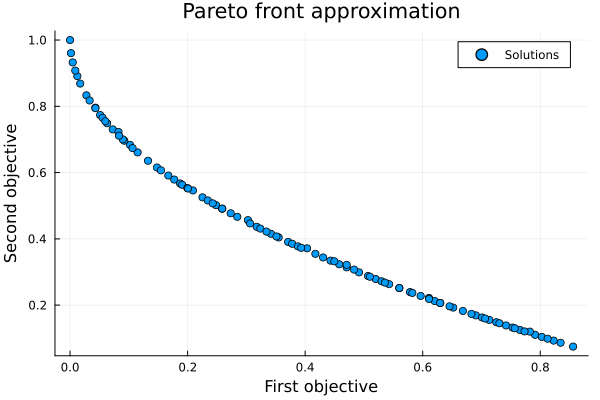

In [5]:
using Plots
 
#data to plot
x = [solution.objectives[1] for solution in solver.foundSolutions];
y = [solution.objectives[2] for solution in solver.foundSolutions];
 
gr();
 
scatter(x, y,  title = "Pareto front approximation", label = "Solutions")
xlabel!("First objective")
ylabel!("Second objective")

## NSGA-II configured with an external archive

As we want to define a NSGA-II variant, we have to rely on the `EvolutionaryAlgorithm` struct. This implies that all the components of the algorithm must be indicated. The external archive is incorporated into NSGA-II by using a `sequentialEvaluationWithArchive` component, which adds the evaluated solutions to the archive.

In [6]:
# Target problem 
problem = zdt1Problem()

ContinuousProblem{Float64}(Bounds{Float64}[Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0)  …  Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0)], Function[var"#97#100"(), var"#98#101"{var"#evalG#99"}(var"#evalG#99"())], Function[], "ZDT1")

The first step is to create a solver from the `EvolutionaryAlgorith()` struct and adding to them all the algorithm parameters, starting by the problem, the population size, and the offspring population size:

In [7]:
nsgaIIWithArchive::EvolutionaryAlgorithm = EvolutionaryAlgorithm()
nsgaIIWithArchive.name = "NSGA-II"

nsgaIIWithArchive.problem = problem
nsgaIIWithArchive.populationSize = 100
nsgaIIWithArchive.offspringPopulationSize = 100

100

The initial population is created by using the `DefaultSolutionsCreation` component, which invokes the `createSolution(problem)` function to create the solutions:

In [8]:
nsgaIIWithArchive.solutionsCreation = DefaultSolutionsCreation((problem = solver.problem, numberOfSolutionsToCreate = solver.populationSize))

DefaultSolutionsCreation(NamedTuple{(:problem, :numberOfSolutionsToCreate), Tuple{Problem, Int64}}((ContinuousProblem{Float64}(Bounds{Float64}[Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0)  …  Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0)], Function[var"#97#100"(), var"#98#101"{var"#evalG#99"}(var"#evalG#99"())], Function[], "ZDT1"), 100)), defaultSolutionsCreation)

A `CrowdingDistanceArchive`, with a maximum size equals to the population size, is created and incorporated into the `SequentialEvaluationWithArchive` component. This way, whenever a new solution is evaluated, it is inserted into the archive.

In [9]:
externalArchive = CrowdingDistanceArchive(solver.populationSize, ContinuousSolution{Float64})
nsgaIIWithArchive.evaluation = SequentialEvaluationWithArchive((archive = externalArchive, problem = solver.problem))

SequentialEvaluationWithArchive(NamedTuple{(:archive, :problem), Tuple{Archive, Problem}}((CrowdingDistanceArchive{ContinuousSolution{Float64}}(100, NonDominatedArchive{ContinuousSolution{Float64}}(ContinuousSolution{Float64}[], compareForDominance)), ContinuousProblem{Float64}(Bounds{Float64}[Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0)  …  Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0)], Function[var"#97#100"(), var"#98#101"{var"#evalG#99"}(var"#evalG#99"())], Function[], "ZDT1"))), sequentialEvaluationWithArchive)

The `Termination` component is set to stop when a maximum number of function evaluations have been reached:

In [10]:
nsgaIIWithArchive.termination = TerminationByEvaluations((numberOfEvaluationsToStop = 25000, ))

TerminationByEvaluations((numberOfEvaluationsToStop = 25000,), terminationByEvaluations)

The `Variation` component is `CrossoverAndMutationVariation`, so the crossover and mutation operator have to be specified. A key parameter is the `offspringPopulationSize`, as it indicates to the `Variation` how many solutions the component must return. Additionally, the `Variation` computes internally the mating pool size, i.e., the number of solutions that the `Selection` component has to produce in order to allow the `Variation` component to produce the required number of offspring solutions.

In [11]:
mutation = PolynomialMutation((probability=1.0/numberOfVariables(problem), distributionIndex=20.0, bounds=problem.bounds))
crossover = SBXCrossover((probability=1.0, distributionIndex=20.0, bounds=problem.bounds))

nsgaIIWithArchive.variation = CrossoverAndMutationVariation((offspringPopulationSize = nsgaIIWithArchive.offspringPopulationSize, crossover = crossover, mutation = mutation))

CrossoverAndMutationVariation(NamedTuple{(:offspringPopulationSize, :crossover, :mutation), Tuple{Int64, CrossoverOperator, MutationOperator}}((100, SBXCrossover((probability = 1.0, distributionIndex = 20.0, bounds = Bounds{Float64}[Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0)  …  Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0)]), 2, 2, sbxCrossover), PolynomialMutation((probability = 0.03333333333333333, distributionIndex = 20.0, bounds = Bounds{Float64}[Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64}(0.0, 1.0), Bounds{Float64

The `Selection` component applies binary tournament to get the required mating pool

In [12]:
nsgaIIWithArchive.selection = BinaryTournamentSelection((matingPoolSize = nsgaIIWithArchive.variation.matingPoolSize, comparator = compareRankingAndCrowdingDistance))

BinaryTournamentSelection(NamedTuple{(:matingPoolSize, :comparator), Tuple{Int64, Function}}((100, compareRankingAndCrowdingDistance)), binaryTournamentMatingPoolSelection)

The `Replacement` in NSGA-II is based on dominance ranking and the crowding distance density estimator

In [16]:
nsgaIIWithArchive.replacement = RankingAndDensityEstimatorReplacement((dominanceComparator = compareForDominance, ))

RankingAndDensityEstimatorReplacement(NamedTuple{(:dominanceComparator,), Tuple{Function}}((compareForDominance,)), rankingAndDensityEstimatorReplacement)

The NSGA-II variant with the external archive are ready to be executed.

In [17]:
startingTime = Dates.now()
optimize(nsgaIIWithArchive)
endTime = Dates.now()

println("Computing time: ", (endTime - startingTime))

Computing time: 3353 milliseconds


The result of the algorithm execution is the external archive

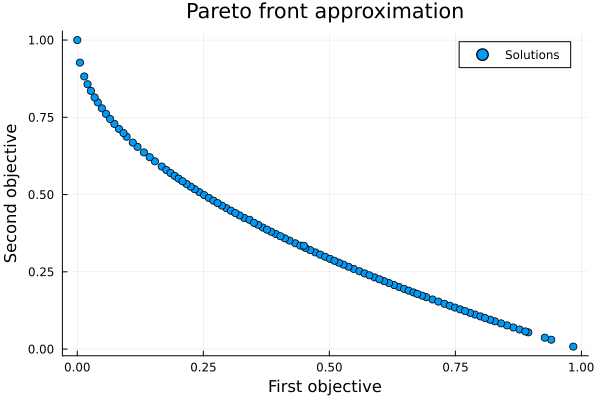

In [18]:
#data to plot
x = [solution.objectives[1] for solution in getSolutions(externalArchive)];
y = [solution.objectives[2] for solution in getSolutions(externalArchive)];
 
gr();
 
scatter(x, y,  title = "Pareto front approximation", label = "Solutions")
xlabel!("First objective")
ylabel!("Second objective")

We observe a remarkable improvement in the diversity of the solutions when using the archive at the cost of an overhead in the total computing time.